## Modules

In [86]:
import os
from tqdm import tqdm

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, correlate, butter, freqs, filtfilt
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem
from signal_analysis import SignalAnalysis
from scipy.optimize import curve_fit
from WFmovie_mod import *

import tifffile as tff
import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt


cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## Analysis Functions

In [1]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files.sort()
    return files

def motion_correction():
    pass

def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    return binned_frame

def lowpass_filter(sig:list, cutoff:float=1, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        sig (list): 1D array of data (timeseries)
        cutoff (float): cutoff frequency.  Defaults to 1
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, sig, axis=0)
    return filtered_data


def regress_drift(sig:list, time:list, save_path, wl:int=530)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        wl (int): wavelength of light corresponding to data, necessary for saving data as npy. Defaults to 530
        filter (bool): activate Defaults to False
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """
    def droite(x, a, b):
        return a*x + b
    
    print("Global regression")
    popt, pcov = curve_fit(droite, time, sig)
    pcov = None
    sig_r = sig/droite(time, *popt)

    return sig_r


def prepToCompute(sig:list, time:list, wl:int=530, cutoff:float=1, fs:float=10, order:int=5, bin_pixel=None):
    # passer motion correction, bin, lowpass, regress
    pass

def convertToHb(data_green, data_red):
    lambda1 = 450 #nm
    lamba2 = 700 #nm
    npoints = 1000
    baseline_hbt = 100 #uM
    baseline_hbo = 60 #uM
    baseline_hbr = 40 #uM
    rescaling_factor = 1e6
    
    eps_pathlength = ioi_epsilon_pathlength(lambda1, lamba2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter=None)
    Ainv = np.linalg.pinv(eps_pathlength)*rescaling_factor
    ln_green = -np.log(data_green.flatten())
    ln_red = -np.log(data_red.flatten())
    ln_R = np.concatenate((ln_green.reshape(1,len(ln_green)),ln_red.reshape(1,len(ln_green))))
    Hbs = np.matmul(Ainv, ln_R)
    d_HbO = Hbs[0].reshape(np.shape(data_green))
    d_HbR = Hbs[1].reshape(np.shape(data_green))
    # Protection against aberrant data points
    np.nan_to_num(d_HbO, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    np.nan_to_num(d_HbR, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    return d_HbO, d_HbR


def absorptionCoefficientVariation(intensity:list, wavelength:int=530, dim:int=3) -> list:
    """Calculates the absorption coefficient variation for a specific wavelength

    Args:
        intensity (list): light signal over time
        wavelength (int, optional): wavelength of light, either 530 or 625 nm. Defaults to 530.
        dim (int, optional): dimension of data. Defaults to 3.

    Returns:
        list: variation of mu_a coefficient over time
    """
    if wavelength == 530:
        X = 0.371713e-3            # m
    elif wavelength == 625:
        X = 3.647821e-3            # m
    else:
        print('Wrong wavelength input: 530 or 625 only')
        return None
    
    if dim == 3:
        iniIntens = intensity[:,:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 2:
        iniIntens = intensity[:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 1:
        iniIntens = intensity[0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    # np.where(iniIntens == 0, 1, iniIntens)
    # print(np.shape(iniIntens))
    # with open('iniIntens{}.txt'.format(wavelength), 'w') as outfile:
    #     for dataslice in iniIntens:
    #         np.savetxt(outfile, dataslice)
    return mu

def oxygenation(greenData: list, redData: list, dim:int=3) -> tuple:
    """Generates a tuple that contains the variation of HbO and HbR concentrations over time

    Args:
        greenData (list): 530 nm absorption coefficient evolution in time
        redData (list): 625 nm absorption coefficient evolution in time
        dim (int, optional): _description_. Defaults to 3.

    Returns:
        tuple: variation of HbR and HbO over time (delta c_HbR, delta c_HbO)
    """

    mu_530 = absorptionCoefficientVariation(greenData, 530, dim)
    mu_625 = absorptionCoefficientVariation(redData, 625, dim)

    eHbO_530 = 39956.8e2      # m-1 M-1
    eHbR_530 = 39036.4e2
    eHbO_625 = 740.8e2
    eHbR_625 = 5763.4e2

    dc_HbR = (eHbO_530*mu_625 - eHbO_625*mu_530)/(eHbO_530*eHbR_625 + eHbO_625*eHbR_530)
    dc_HbO = (eHbR_530*mu_625 - eHbR_625*mu_530)/(eHbR_530*eHbO_625 + eHbR_625*eHbO_530)

    return (dc_HbR, dc_HbO)

## Open data

In [4]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"

green = np.loadtxt(pathBase + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
red = np.loadtxt(pathBase + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]

green_t = np.load(pathBase + "\\530ts.npy")
red_t = np.load(pathBase + "\\625ts.npy")

## AP time series

In [5]:
FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(green_t)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(green_t-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(green_t))
AP_series[AP_idx] = 1

## Quick plot

(0.0, 100.0)

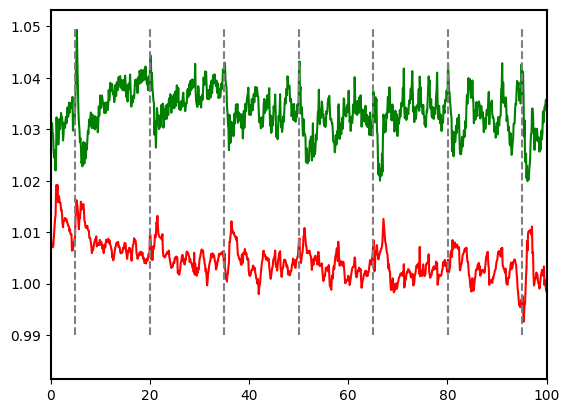

In [6]:
plt.plot(red_t, red/np.mean(red), 'r-')
plt.plot(green_t, green/np.mean(green)+0.03, 'g-')
plt.vlines(red_t[AP_idx], 0.99, 1.05, colors='grey', linestyles='--')
plt.xlim(0, 100)
# plt.savefig('red_600zoomed.png', dpi=600)

## Function testing

Green data loaded
Global regression
Filtering
Saving data
---
Red data loaded
Global regression
Filtering
Saving data
---
Convert to dHb
Done


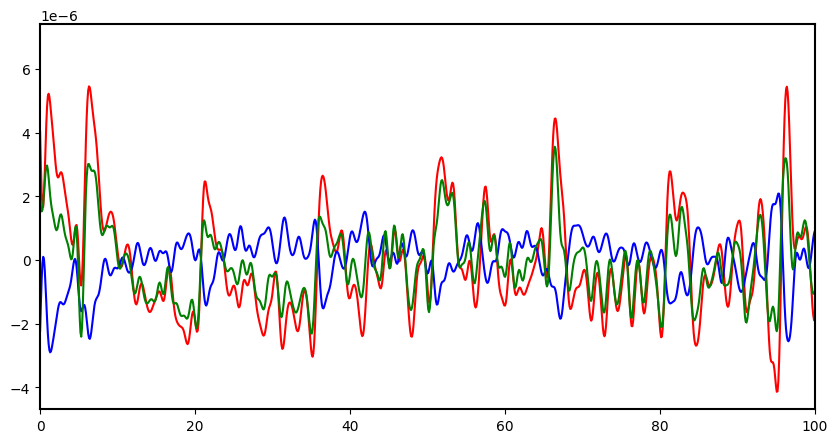

In [81]:
def dHb_pipeline(data_path, save_path, filter=False, cutoff=0.2):
    # pathBase = folder_path  #r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
    # os.chdir(pathBase)

    # process green
    # open data, prep, save data
    green = np.loadtxt(data_path + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
    green_t = np.load(data_path + "\\530ts.npy")
    print("Green data loaded")
    prepToCompute(green, green_t, save_path=data_path, wl=530, filter=filter, cutoff=cutoff)
    green = np.load(data_path + "\\530preped.npy")
    # C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition\530preped.npy

    # process red    
    red = np.loadtxt(data_path + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]
    red_t = np.load(data_path + "\\625ts.npy")
    print("Red data loaded")
    prepToCompute(red, red_t, save_path=data_path, wl=625, filter=filter, cutoff=cutoff)
    red = np.load(data_path + "\\625preped.npy")

    # convert to hb
    print("Convert to dHb")
    d_HbO, d_HbR = convert_to_hb(green, red, save_path)

    # save processed data
    # fig = plt.figure(figsize=(10,5))
    # plt.plot(green_t, d_HbO, 'r-')
    # plt.plot(red_t, d_HbR, 'b-')
    # plt.plot(red_t, d_HbO+d_HbR, 'g-')
    # plt.xlim(0, 100)

    print("Done")


test = True
if test:
    data_path = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
    save_path = r"C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition\analysisPipeline"
    # prepData(green, green_t, save_path=save_path, wl=530, filter=False)
    # dHb_pipeline(data_path, save_path, filter=True, cutoff=1)

## Tests avec tiff

In [82]:
data_path = r"Y:\gGermain\2024-07-18"
save_path = data_path

# create 3d array from stack
files = identify_files(data_path+"\\530", "tif")
files=files[:250]
for idx, file in tqdm(enumerate(files)):
    frame = tff.TiffFile(data_path+"\\530\\"+file).asarray()
    if idx == 0:
        num_frames = len(files)
        frame_shape = frame.shape
        stack_shape = (num_frames, frame_shape[0], frame_shape[1])
        _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
    _3d_stack[idx,:,:] = frame

# np.save(save_path+"\\530_stackraw.npy", _3d_stack)





250it [00:14, 17.05it/s]


## Correlation avec HbO HbR

lag: 1.3 s
lag: 1.6 s


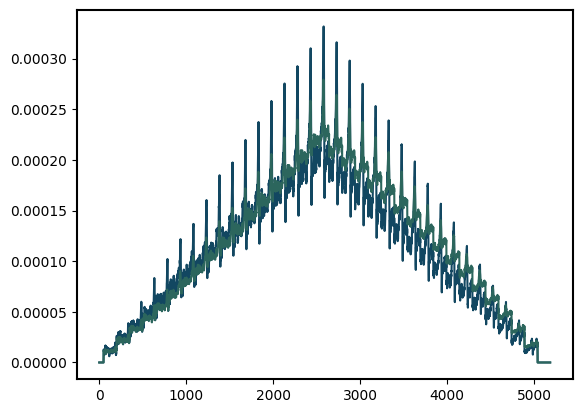

In [348]:
correlation = correlate(AP_series, HbO*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)
correlation = correlate(AP_series, HbR*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)